In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tsa.stattools import adfuller 
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima_model import ARIMA
from math import sqrt
from pmdarima import auto_arima







ModuleNotFoundError: No module named 'pmdarima'

In [2]:
df=pd.read_csv('Denawaka_project.csv')
df.head()












,Year,Month,Rainfall,Temp_min,Temp_max,Hum_min,Hum_max
0,2010,January,233.6,22.1,32.1,NaN,NaN
1,2010,February,111.9,22.6,33.9,NaN,NaN
2,2010,March,157.5,23.1,35.2,NaN,NaN
3,2010,April,438.3,23.7,33.5,NaN,NaN
4,2010,May,658.5,24.0,31.8,NaN,NaN


In [3]:
df["Time"]=df["Year"].astype(str)+"-"+df["Month"].astype(str)





In [4]:
df.head()




,Year,Month,Rainfall,Temp_min,Temp_max,Hum_min,Hum_max,Time
0,2010,January,233.6,22.1,32.1,NaN,NaN,2010-January
1,2010,February,111.9,22.6,33.9,NaN,NaN,2010-February
2,2010,March,157.5,23.1,35.2,NaN,NaN,2010-March
3,2010,April,438.3,23.7,33.5,NaN,NaN,2010-April
4,2010,May,658.5,24.0,31.8,NaN,NaN,2010-May


In [5]:
hum_max=df[["Time","Hum_max"]]
hum_max.head()








,Time,Hum_max
0,2010-January,NaN
1,2010-February,NaN
2,2010-March,NaN
3,2010-April,NaN
4,2010-May,NaN


In [6]:
hum_max['Time']=pd.to_datetime(hum_max['Time'])

<ipython-input-6-14e8545da2ed>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hum_max['Time']=pd.to_datetime(hum_max['Time'])


In [7]:
hum_max.head(20)

,Time,Hum_max
0,2010-01-01,NaN
1,2010-02-01,NaN
2,2010-03-01,NaN
3,2010-04-01,NaN
4,2010-05-01,NaN
5,2010-06-01,NaN
6,2010-07-01,NaN
7,2010-08-01,NaN
8,2010-09-01,NaN
9,2010-10-01,NaN


In [8]:
#Checking for missing values
hum_max.isna().sum()






Time        0
Hum_max    23
dtype: int64

In [9]:
#Setting the time index
hum_max.set_index('Time',inplace=True)

In [10]:
#Creating complete sequence
hum_max=hum_max.resample('MS').first()

In [11]:
#filling missing values
hum=hum_max.fillna(method='bfill')
hum.head(20)






,Hum_max
Time,
2010-01-01,95.0
2010-02-01,95.0
2010-03-01,95.0
2010-04-01,95.0
2010-05-01,95.0
2010-06-01,95.0
2010-07-01,95.0
2010-08-01,95.0
2010-09-01,95.0


In [12]:
#Checking for missing values
hum.isna().sum()


Hum_max    0
dtype: int64

In [13]:
hum = hum.rename(columns = {'Hum_max': 'Humidity'})
hum.head()








,Humidity
Time,
2010-01-01,95.0
2010-02-01,95.0
2010-03-01,95.0
2010-04-01,95.0
2010-05-01,95.0


In [14]:
hum.columns



Index(['Humidity'], dtype='object')

In [15]:
hum.head()


,Humidity
Time,
2010-01-01,95.0
2010-02-01,95.0
2010-03-01,95.0
2010-04-01,95.0
2010-05-01,95.0


<AxesSubplot:xlabel='Time'>

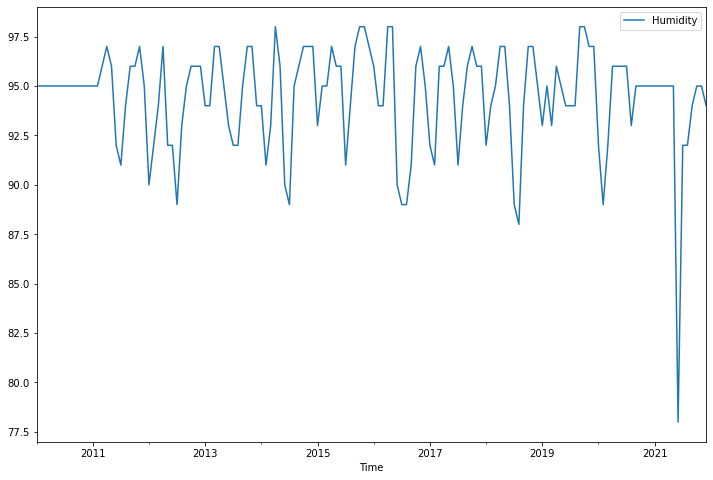

In [16]:
hum.plot(figsize=(12,8))



 No trend. But some evidence for seasonality

# Testing For Stationarity

In [17]:
### ADF Test
test_result=adfuller(hum['Humidity'])
#Ho: The series is non stationary
#H1: The series is stationary

def adfuller_test(x):
    result=adfuller(x)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")
    
adfuller_test(hum['Humidity'])






ADF Test Statistic : -3.8730887048540805
p-value : 0.0022420723600267826
#Lags Used : 13
Number of Observations Used : 130
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


In [18]:
# KPSS test
from statsmodels.tsa.stattools import kpss
def kpss_test(series, **kw):    
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    # Format Output
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')

kpss_test(hum['Humidity'])


KPSS Statistic: 0.1166696869021571
p-value: 0.1
num lags: 9
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary


C:\Users\isuru\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In [19]:
#PhillipsPerron Test
from arch.unitroot import PhillipsPerron

pp = PhillipsPerron(hum['Humidity'].astype(float))
print(pp.summary().as_text())





     Phillips-Perron Test (Z-tau)    
Test Statistic                 -7.442
P-value                         0.000
Lags                               14
-------------------------------------

Trend: Constant
Critical Values: -3.48 (1%), -2.88 (5%), -2.58 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


Therefore the series is stationary

# ACF and PACF plots

C:\Users\isuru\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


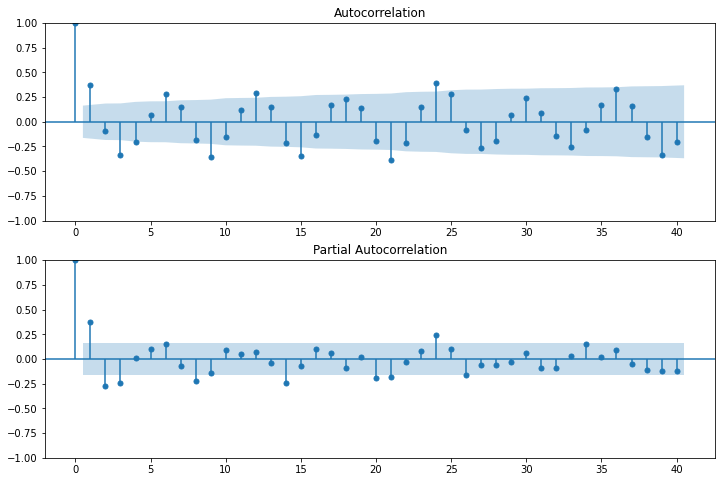

In [20]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(hum['Humidity'],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(hum['Humidity'],lags=40,ax=ax2)


According to the PACF and ACF plots, series is likely to follow a MA process. But since we are following step-wise, better to start with p=3,q=1, d=0

In [ ]:
arima_model=auto_arima(hum['Humidity'].astype(float),start_p=0,start_q=1,max_p=3,max_q=4,start_P=0,start_Q=0,max_P=3,max_Q=3,max_D=2,alpha=0.05,m=12,seasonal=True,error_action='warn',trace=True,supress_warnings=True,stepwise=False,random_state=20,n_fits=70,maxiter=70,
                      information_criterion='aic')



 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=693.102, Time=0.16 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=686.253, Time=0.27 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : AIC=668.567, Time=1.06 sec
 ARIMA(0,0,0)(0,0,3)[12] intercept   : AIC=667.997, Time=1.93 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=679.304, Time=0.96 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=666.140, Time=1.44 sec
 ARIMA(0,0,0)(1,0,2)[12] intercept   : AIC=670.240, Time=7.75 sec
 ARIMA(0,0,0)(1,0,3)[12] intercept   : AIC=669.998, Time=8.74 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=697.968, Time=5.44 sec
 ARIMA(0,0,0)(2,0,1)[12] intercept   : AIC=inf, Time=8.03 sec
 ARIMA(0,0,0)(2,0,2)[12] intercept   : AIC=672.506, Time=8.35 sec
 ARIMA(0,0,0)(2,0,3)[12] intercept   : AIC=inf, Time=14.31 sec


In [3]:
?auto_arima

Object `auto_arima` not found.


# Forecast using the model

In [22]:
model=sm.tsa.statespace.SARIMAX(hum["Humidity"].astype('float'),order=(1,0,2),seasonal_order=(2,0,0,12))
results=model.fit()
results.summary()



C:\Users\isuru\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                            Humidity   No. Observations:                  144
Model:             SARIMAX(1, 0, 2)x(2, 0, [], 12)   Log Likelihood                -325.425
Date:                             Wed, 13 Apr 2022   AIC                            662.850
Time:                                     22:34:02   BIC                            680.669
Sample:                                 01-01-2010   HQIC                           670.090
                                      - 12-01-2021                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000    9.3e-06   1.08e+05      0.000       1.000       1.000
ma.L1         -0.6969      0.089     -7.824      0.000      -0.871      -0.522
ma.L2         -0.2798      0.092     -3.034      0.002      -0.461      -0.099
ar.S.L12       0.1858      0.142      1.312      0.189      -0.092       0.463
ar.S.L24       0.3940      0.115      3.412      0.001       0.168       0.620
sigma2         4.8362      0.205     23.603      0.000       4.435       5.238
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):              2854.99
Prob(Q):                              0.80   Prob(JB):                         0.00
Heteroskedasticity (H):               3.63   Skew:                            -3.33
Prob(H) (two-sided):                  0.00   Kurtosis:                        23.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [27]:
hum.head()

,Humidity,forecast
Time,,
2010-01-01,95.0,NaN
2010-02-01,95.0,NaN
2010-03-01,95.0,NaN
2010-04-01,95.0,NaN
2010-05-01,95.0,NaN


In [28]:
hum.tail()

,Humidity,forecast
Time,,
2021-08-01,92.0,NaN
2021-09-01,94.0,NaN
2021-10-01,95.0,NaN
2021-11-01,95.0,NaN
2021-12-01,94.0,NaN


In [48]:
beg_dt='2017-01-01'
end_dt='2021-12-01'

<AxesSubplot:xlabel='Time'>

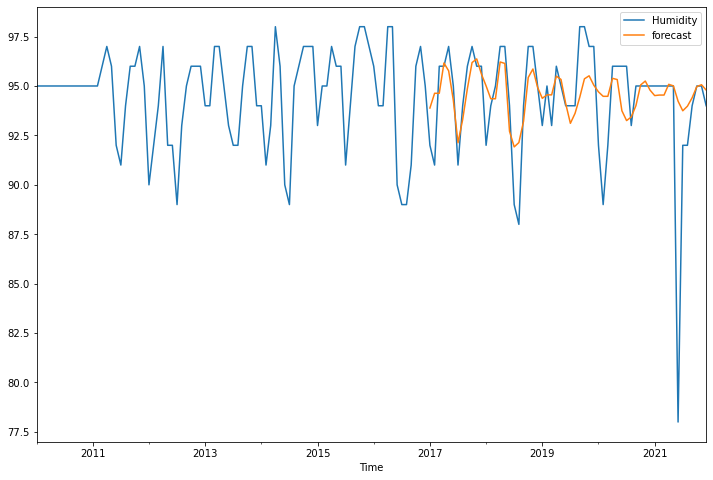

In [49]:
hum['forecast']=results.predict(start=beg_dt,end=end_dt,dynamic=True)
hum[['Humidity','forecast']].plot(figsize=(12,8))
















In [51]:
hum.tail()



,Humidity,forecast
Time,,
2021-08-01,92.0,93.978504
2021-09-01,94.0,94.405297
2021-10-01,95.0,94.967195
2021-11-01,95.0,95.063963
2021-12-01,94.0,94.792453
